# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

### 1.2 Collect images using OpenCV

In [1]:
import os
import time
import uuid # lets you create uniform unique id
import cv2

In [ ]:
IMAGES_PATH=os.path.join('data','images')
number_images=30

In [ ]:
cap=cv2.VideoCapture(0) # Opens webcam (0 for default, 1 for external/secondary camera)
for imgnum in range(number_images):
  print("Collecting image {}".format(imgnum))
  ret, frame=cap.read() # captures frame (ret is a boolean indicating the frame was successfully captured. frame is the actual image (NumPy array).)
  imgname=os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg') # each image is given a unique filename using uuid.uuid1()
  cv2.imwrite(imgname, frame) # Saves the frame to IMAGES_PATH
  cv2.imshow('frame', frame)
  time.sleep(0.5)

  if cv2.waitKey(1) & 0xFF==ord('q'):
    break
cap.release()
cv2.destroyAllWindows()

### 1.3 Annotate Images with LabelMe

In [ ]:
!labelme

2025-08-16 15:38:45.850 | INFO     | labelme.config:get_config:66 - Loading config file from: C:\Users\samarth\.labelmerc
2025-08-16 15:38:47.893 | DEBUG    | labelme.widgets.canvas:set_ai_model_name:140 - Setting AI model to 'sam2:latest'


# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [2]:
import tensorflow as tf
import cv2
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [6]:
# Avoid OOM errors by setting GPU Memory Consumptions Growth
gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu,True)

In [7]:
tf.test.is_gpu_available('GPU')

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

### 2.3 Load image into TF data pipeline

In [ ]:
images = tf.data.Dataset.list_files("data\images\*.jpg")

<>:1: SyntaxWarning: invalid escape sequence '\i'
<>:1: SyntaxWarning: invalid escape sequence '\i'
C:\Users\samarth\AppData\Local\Temp\ipykernel_19152\1140919288.py:1: SyntaxWarning: invalid escape sequence '\i'
  images = tf.data.Dataset.list_files("data\images\*.jpg")


In [ ]:
images.as_numpy_iterator().next()

b'data\\images\\778eb23f-7a88-11f0-9506-14857fbc37ab.jpg'

In [3]:
# Function to load images
def load_images(x):
    byte_img=tf.io.read_file(x)
    img=tf.io.decode_jpeg(byte_img)
    return img

In [ ]:
images=images.map(load_images)

NameError: name 'images' is not defined

In [ ]:
images.as_numpy_iterator().next()

array([[[145, 152, 145],
        [137, 144, 137],
        [143, 149, 145],
        ...,
        [178, 198, 189],
        [184, 204, 193],
        [158, 178, 166]],

       [[143, 150, 143],
        [139, 146, 139],
        [144, 150, 146],
        ...,
        [172, 191, 185],
        [183, 203, 194],
        [176, 196, 187]],

       [[145, 150, 146],
        [145, 150, 146],
        [147, 152, 148],
        ...,
        [167, 183, 182],
        [175, 191, 190],
        [185, 201, 200]],

       ...,

       [[ 92,  96,  95],
        [ 96, 100,  99],
        [ 99, 104, 100],
        ...,
        [120, 131, 127],
        [120, 131, 127],
        [113, 124, 120]],

       [[ 96,  98,  97],
        [ 99, 101, 100],
        [102, 104, 101],
        ...,
        [118, 127, 124],
        [112, 121, 120],
        [107, 116, 115]],

       [[ 97,  99,  98],
        [ 99, 101, 100],
        [101, 103, 100],
        ...,
        [104, 110, 108],
        [ 98, 104, 104],
        [101, 107, 107]]

### 2.4 View Raw Images with Matplotlib

In [ ]:
image_generator = images.batch(4).as_numpy_iterator()

In [ ]:
plot_images= image_generator.next()

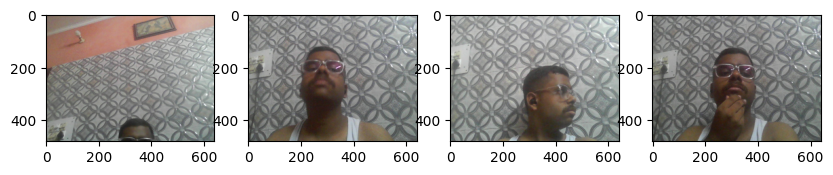

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(10, 10))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

# 3. Partition UnAugmented Data

### 3.1 Manually Split Data into Train, Test, and Val

In [ ]:
90*0.7 # 63 to train

62.99999999999999

In [ ]:
90*.15 # 14 and 13 to test and val

13.5

### 3.2 Move the matching Labels

In [ ]:
for folder in ["train", "val", "test"]:
    for file in os.listdir(os.path.join('data',folder,'images')):
        filename=file.split('.')[0]+'.json'
        existing_filepath=os.path.join('data','labels',filename)
        if os.path.exists(existing_filepath):
            new_filepath=os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)

# 4. Apply Image Augmentation on Images and Labels using Albumentation

In [ ]:
import albumentations as alb

In [ ]:
augmentor = alb.Compose([
    alb.RandomCrop(width=450, height=456),
    alb.HorizontalFlip(p=0.5),
    alb.RandomBrightnessContrast(p=0.2),
    alb.RandomGamma(p=0.2),
    alb.RGBShift(p=0.2),
    alb.VerticalFlip(p=0.5),
],
    bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels'])
)

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [ ]:
img = cv2.imread(os.path.join('data', 'train', 'images', '7a4c59a0-7a88-11f0-8e98-14857fbc37ab.jpg'))

In [ ]:
with open(os.path.join('data', 'train', 'labels', '7a4c59a0-7a88-11f0-8e98-14857fbc37ab.json'),'r') as f:
    label=json.load(f)

In [ ]:
label['shapes'][0]['points']

[[209.47368421052633, 118.07017543859648],
 [463.859649122807, 397.0175438596491]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [ ]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [ ]:
coords

[209.47368421052633, 118.07017543859648, 463.859649122807, 397.0175438596491]

In [ ]:
coords = list(np.divide(coords,[640,480,640,480]))

In [ ]:
coords

[np.float64(0.3273026315789474),
 np.float64(0.24597953216374266),
 np.float64(0.7247807017543859),
 np.float64(0.8271198830409356)]

### 4.4 Apply Augmentations and view results

In [ ]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [ ]:
augmented['bboxes']

[[0.10253414577907984,
  0.21068020975380614,
  0.6678362528483073,
  0.8224068984650729]]

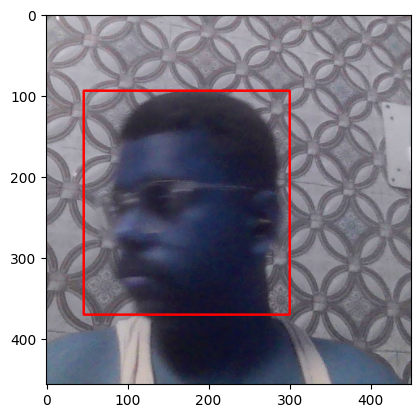

In [ ]:
cv2.rectangle(augmented['image'],
            tuple(np.multiply(augmented['bboxes'][0][:2],[450,450]).astype(int)),
            tuple(np.multiply(augmented['bboxes'][0][2:],[450,450]).astype(int)),
            color=(255,0,0), thickness=2)
plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [ ]:
for partition in ['train','test','val']:
    for image in os.listdir(os.path.join('data',partition,'images')):
        img = cv2.imread(os.path.join('data',partition,'images',image))

        coords=[0,0,0.00001,0.00001]
        label_path=os.path.join('data', partition, 'labels', f'{image.split('.')[0]}.json')
        if os.path.exists(label_path):
            with open(label_path,'r') as f:
                label=json.load(f)
            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords,[640,480,640,480])) # normalized bounding box in [x1,y1,x2,y2]

        try:
            for x in range(60):
                augmented=augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data',partition,'images',f'{image.split(".")[0]}.{x}.jpg'),augmented['image'])

                annotation={}
                annotation['image']=image

                # ✅ Check if this image has a label file (annotation)
                if os.path.exists(label_path):
                    # If augmentation removed/cropped out the face, then no bounding boxes remain
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0,0,0,0]    # Placeholder (no bbox)
                        annotation['class'] = 0           # Class 0 → No face
                    else:
                    # If bbox is still present after augmentation
                        annotation['bbox'] = augmented['bboxes'][0]  # Take the first bbox (face)
                        annotation['class'] = 1                     # Class 1 → Face present
                else:
                # If no label existed for this image in the first place (background image)
                    annotation['bbox'] = [0,0,0,0]    # No bbox
                    annotation['class'] = 0           # Class 0 → No face


                with open(os.path.join('aug_data',partition,'labels',f'{image.split(".")[0]}.{x}.json'),'w') as f:
                    json.dump(annotation,f)

        except Exception as e:
            print(f"Error processing {image}: {e}")

### 5.2 Load Augmented Images to Tensorflow Dataset

In [ ]:
# Load all image file paths from the training folder
train_images = tf.data.Dataset.list_files("aug_data/train/images/*.jpg", shuffle=False)

# Map each file path to an actual image tensor
train_images = train_images.map(load_images)
# load_images() does:
#   1. Read image bytes from disk
#   2. Decode into a tensor (H, W, C)

# Resize every image to 120x120 (fixed input size required by the model)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))

# Normalize pixel values from [0–255] → [0–1] (better training stability)
train_images = train_images.map(lambda x: x/255)

In [ ]:
test_images = tf.data.Dataset.list_files("aug_data/test/images/*.jpg", shuffle=False)
test_images = test_images.map(load_images)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [ ]:
val_images = tf.data.Dataset.list_files("aug_data/val/images/*.jpg", shuffle=False)
val_images = val_images.map(load_images)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [12]:
train_images.as_numpy_iterator().next()

array([[[0.4920588 , 0.42882353, 0.5222549 ],
        [0.48254904, 0.3840196 , 0.49676472],
        [0.50235295, 0.38813725, 0.47539216],
        ...,
        [0.48539215, 0.40882352, 0.47362745],
        [0.4598039 , 0.37872547, 0.45754904],
        [0.60519606, 0.5177451 , 0.6009804 ]],

       [[0.5217647 , 0.4585294 , 0.54470587],
        [0.4548039 , 0.35970587, 0.46215686],
        [0.495     , 0.39764705, 0.4839216 ],
        ...,
        [0.42382354, 0.36656865, 0.4261765 ],
        [0.40529412, 0.33980393, 0.41343138],
        [0.6267647 , 0.57284313, 0.6478431 ]],

       [[0.5602941 , 0.49068627, 0.56960785],
        [0.4509804 , 0.35686275, 0.45784312],
        [0.45637256, 0.38039216, 0.45588234],
        ...,
        [0.42941177, 0.3480392 , 0.422549  ],
        [0.3867647 , 0.3122549 , 0.39754903],
        [0.47696078, 0.4107843 , 0.50392157]],

       ...,

       [[0.75490195, 0.6764706 , 0.7745098 ],
        [0.8102941 , 0.7230392 , 0.8127451 ],
        [0.86715686, 0

# 6. Prepare labels

### 6.1 Build Label loading function

In [13]:
def load_labels(label_path):
    # Convert TF tensor path -> Python string
    path = label_path.numpy().decode("utf-8")

    # Open JSON file
    with open(path, 'r') as f:
        label = json.load(f)

    # Convert to Tensors
    class_id = tf.convert_to_tensor(label['class'], dtype=tf.uint8)
    bbox = tf.convert_to_tensor(label['bbox'], dtype=tf.float16)  # [x1,y1,x2,y2]

    return class_id, bbox

### 6.2 Load Labels to Tensoflow Dataset

In [ ]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(func=load_labels, inp=[x], Tout=[tf.uint8, tf.float16]))

In [ ]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(func=load_labels, inp=[x], Tout=[tf.uint8, tf.float16]))

In [ ]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(func=load_labels, inp=[x], Tout=[tf.uint8, tf.float16]))

In [17]:
train_labels.as_numpy_iterator().next()

(np.uint8(1), array([0.2183 , 0.01409, 0.7017 , 0.586  ], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [18]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3780, 3780, 840, 840, 780, 780)

### 7.2 Create Final Datasets (Images/Labels)

In [19]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(tf.data.AUTOTUNE) # TensorFlow dynamically chooses the optimal buffer size based on your CPU, memory, and training speed.

In [20]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(tf.data.AUTOTUNE) # TensorFlow dynamically chooses the optimal buffer size based on your CPU, memory, and training speed.

In [21]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(tf.data.AUTOTUNE) # TensorFlow dynamically chooses the optimal buffer size based on your CPU, memory, and training speed.

In [22]:
train.as_numpy_iterator().next()[1]


(array([1, 1, 1, 1, 1, 1, 1, 1], dtype=uint8),
 array([[0.4333  , 0.304   , 0.8506  , 0.8555  ],
        [0.4233  , 0.3535  , 0.934   , 0.865   ],
        [0.013374, 0.1824  , 0.7153  , 0.734   ],
        [0.388   , 0.      , 0.8037  , 0.4492  ],
        [0.5093  , 0.1416  , 0.967   , 0.774   ],
        [0.4094  , 0.2683  , 1.      , 0.82    ],
        [0.3438  , 0.03665 , 0.76    , 0.642   ],
        [0.      , 0.1032  , 0.524   , 0.748   ]], dtype=float16))

### 7.3 View Images and Annotations

In [23]:
data_samples = train.as_numpy_iterator()

In [24]:
res = data_samples.next()

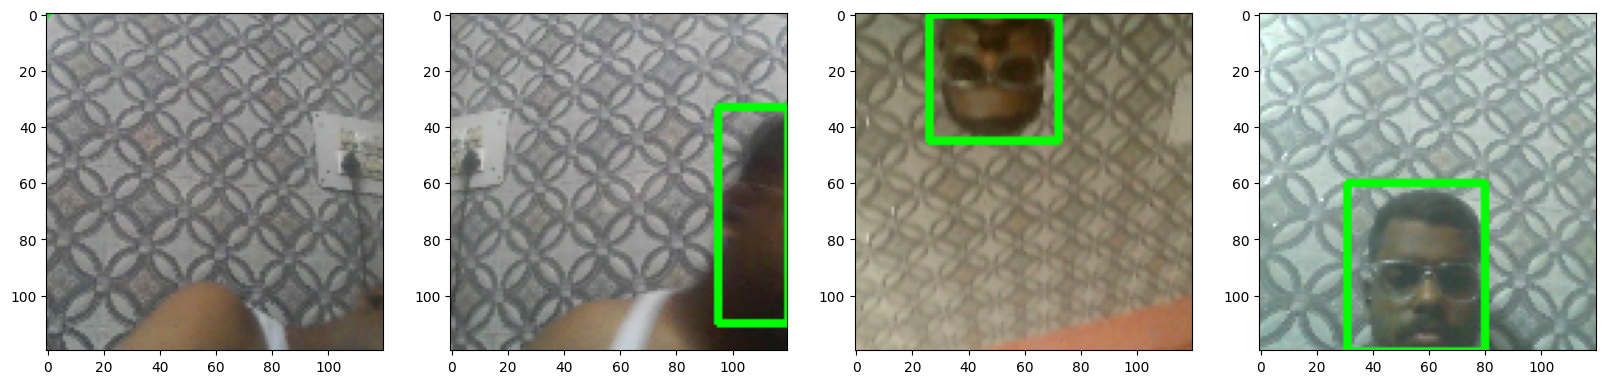

In [25]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]

    # Convert image to uint8 and make it writable
    img_for_draw = (sample_image * 255).astype(np.uint8).copy()

    # need a image of type uint8
    cv2.rectangle(img_for_draw,
                tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
                tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)),
                color=(0, 255, 0),
                thickness=2
    )
    ax[idx].imshow(img_for_draw)

# 8. Building a Deep Learning Model using the Functional Api

### 8.1 Import Layers and Base Network

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [27]:
vgg = VGG16(include_top=False)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [28]:
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

### 8.3 Build an Instance of Network

In [29]:
def build_model():
  input_layer = Input(shape=(120,120,3))

  vgg = VGG16(include_top=False)(input_layer)

  # Classification Model
  f1 = GlobalMaxPooling2D()(vgg)
  class1 = Dense(2048, activation='relu')(f1)
  class2 = Dense(1, activation='sigmoid')(class1)

  # Bounding Box Model
  f2 = GlobalMaxPooling2D()(vgg)
  regress1 = Dense(2048, activation='relu')(f2)
  regress2 = Dense(4, activation='sigmoid')(regress1)

  facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
  return facetracker

### 8.4 Test our Neural Network

In [30]:
facetracker = build_model()

In [31]:
facetracker.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 3, 3, 512) │ 14,714,688 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      2,049 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 4)         │      8,196 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 16,826,181 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
X, y = train.as_numpy_iterator().next()

In [33]:
X.shape

(8, 120, 120, 3)

In [34]:
y

(array([1, 1, 1, 1, 1, 1, 1, 1], dtype=uint8),
 array([[0.2542  , 0.3882  , 0.6973  , 0.946   ],
        [0.2379  , 0.2319  , 0.8174  , 0.7563  ],
        [0.011734, 0.      , 0.578   , 0.709   ],
        [0.1705  , 0.252   , 0.6826  , 0.8022  ],
        [0.538   , 0.528   , 0.941   , 1.      ],
        [0.1248  , 0.02979 , 0.911   , 1.      ],
        [0.04044 , 0.2683  , 0.742   , 0.82    ],
        [0.1528  , 0.5166  , 0.554   , 0.9937  ]], dtype=float16))

In [35]:
classes, coords = facetracker.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [36]:
classes, coords

(array([[0.34016067],
        [0.3203182 ],
        [0.43285906],
        [0.37112984],
        [0.41257006],
        [0.4019537 ],
        [0.36184785],
        [0.33579347]], dtype=float32),
 array([[0.609432  , 0.4703399 , 0.34356797, 0.39500248],
        [0.6420086 , 0.49677074, 0.38964745, 0.37001628],
        [0.5657419 , 0.5164877 , 0.31390995, 0.39090982],
        [0.6450206 , 0.50237054, 0.3743821 , 0.38079527],
        [0.6035159 , 0.5146161 , 0.39499718, 0.39433187],
        [0.5791915 , 0.48466718, 0.37127677, 0.39664108],
        [0.55919516, 0.480439  , 0.3890704 , 0.323608  ],
        [0.60247904, 0.48961008, 0.34012032, 0.37342763]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define optimizer and lr

In [37]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 - 1)/batches_per_epoch

In [38]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


### 9.2 Create Localization Loss and Classification Loss

In [39]:
def localization_loss(y_true, yhat):
  delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))

  h_true = y_true[:,3] - y_true[:,1]
  w_true = y_true[:,2] - y_true[:,0]

  h_pred = yhat[:,3] - yhat[:,1]
  w_pred = yhat[:,2] - yhat[:,0]

  delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true - h_pred))

  return delta_coord + delta_size

In [40]:
classification_loss = tf.keras.losses.BinaryCrossentropy()
regression_loss = localization_loss

### 9.3 Test out Loss Metrics

In [41]:
localization_loss(y[1],coords)

<tf.Tensor: shape=(), dtype=float32, numpy=11.499814987182617>

In [42]:
classification_loss(y[0],classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.9937352538108826>

In [43]:
regression_loss(y[1],coords)

<tf.Tensor: shape=(), dtype=float32, numpy=11.499814987182617>

# 10. Train Neural Network

### 10.1 Create a Custom Model Class

In [91]:
class FaceTracker(Model):
  def __init__(self, facetracker, **kwargs):
    super().__init__(**kwargs)
    self.model = facetracker

  def compile(self, opt, classloss, localizationloss, **kwargs):
    super().compile(**kwargs)
    self.closs = classloss
    self.lloss = localizationloss
    self.opt = opt

  def _split_labels(self, y):
    """
    Handles two cases:
    - Tuple: (class_labels, bbox_coords)
    - Single tensor: first column = class, next 4 = bbox
    """
    if isinstance(y, (tuple, list)):
      y_class, y_bbox = y[0], y[1]
    else:
      y_class = y[:, 0]
      y_bbox = y[:, 1:5]

    # Ensure y_class has shape (batch_size, 1)
    y_class = tf.reshape(y_class, (-1, 1))

    return y_class, y_bbox

  def train_step(self, batch, **kwargs):
    X, y = batch
    y_class, y_bbox = self._split_labels(y)

    with tf.GradientTape() as tape:
      classes, coords = self.model(X, training=True)
      batch_classloss = self.closs(y_class, classes)
      batch_localizationloss = self.lloss(tf.cast(y_bbox, tf.float32), coords)
      total_loss = batch_localizationloss + 0.5 * batch_classloss

    grad = tape.gradient(total_loss, self.model.trainable_variables)
    self.opt.apply_gradients(zip(grad, self.model.trainable_variables))

    return {
        "total_loss": total_loss,
        "class_loss": batch_classloss,
        "regress_loss": batch_localizationloss,
    }

  def test_step(self, batch, **kwargs):
    X, y = batch
    y_class, y_bbox = self._split_labels(y)

    classes, coords = self.model(X, training=False)
    batch_classloss = self.closs(y_class, classes)
    batch_localizationloss = self.lloss(tf.cast(y_bbox, tf.float32), coords)
    total_loss = batch_localizationloss + 0.5 * batch_classloss

    return {
        "total_loss": total_loss,
        "class_loss": batch_classloss,
        "regress_loss": batch_localizationloss,
    }

  def call(self, X, **kwargs):
    return self.model(X, **kwargs)

   # 🔹 Add this for saving support
  def get_config(self):
      config = super().get_config().copy()
      config.update({
          "facetracker_config": self.model.get_config()
      })
      return config

  @classmethod
  def from_config(cls, config):
      facetracker_config = config.pop("facetracker_config")
      facetracker_model = tf.keras.Model.from_config(facetracker_config)
      return cls(facetracker_model, **config)

In [92]:
model = FaceTracker(facetracker)

In [93]:
model.compile(opt, classification_loss, regression_loss)

### 10.2 Train

In [94]:
logdir='logs'

In [95]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [96]:
hist = model.fit(train, epochs=40, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/40
473/473 ━━━━━━━━━━━━━━━━━━━━ 59s 96ms/step - class_loss: 1.3963e-06 - regress_loss: 0.0024 - total_loss: 0.0024 - val_class_loss: 3.0463e-05 - val_regress_loss: 0.1945 - val_total_loss: 0.1945
Epoch 2/40
473/473 ━━━━━━━━━━━━━━━━━━━━ 47s 84ms/step - class_loss: 3.4329e-06 - regress_loss: 0.0030 - total_loss: 0.0030 - val_class_loss: 8.5870e-07 - val_regress_loss: 0.0052 - val_total_loss: 0.0052
Epoch 3/40
473/473 ━━━━━━━━━━━━━━━━━━━━ 81s 84ms/step - class_loss: 1.6936e-06 - regress_loss: 0.0029 - total_loss: 0.0029 - val_class_loss: 5.1461e-08 - val_regress_loss: 0.0068 - val_total_loss: 0.0068
Epoch 4/40
473/473 ━━━━━━━━━━━━━━━━━━━━ 83s 84ms/step - class_loss: 1.1732e-06 - regress_loss: 0.0020 - total_loss: 0.0020 - val_class_loss: 1.2749e-06 - val_regress_loss: 0.0041 - val_total_loss: 0.0041
Epoch 5/40
473/473 ━━━━━━━━━━━━━━━━━━━━ 48s 86ms/step - class_loss: 1.2030e-06 - regress_loss: 0.0023 - total_loss: 0.0023 - val_class_loss: 3.0566e-08 - val_regress_loss: 0.0085 - val

### 10.3 Plot Performance

In [97]:
hist.history

{'class_loss': [7.584268360005808e-07,
  1.7907127585203853e-06,
  6.897155913065944e-08,
  8.661608035254176e-07,
  5.337595698762243e-09,
  4.838222600334063e-10,
  1.0649821025054962e-09,
  1.37535286978685e-11,
  2.015307387637222e-08,
  3.6333954511746924e-08,
  1.5851959460633225e-06,
  5.544085723840908e-08,
  1.5982229228939104e-07,
  1.2753889677696861e-07,
  5.169847554498119e-07,
  6.490164651040686e-06,
  6.7542442749868314e-09,
  5.0641105531212816e-08,
  1.3741157545155147e-06,
  1.6218417613345082e-06,
  1.2960560979990987e-06,
  1.915177278988267e-07,
  1.1644756341411266e-06,
  5.117533987686329e-07,
  4.965122002431599e-07,
  4.887949103249412e-07,
  8.106839644028696e-09,
  3.6766493849427206e-07,
  3.869205613682425e-07,
  3.0656264193851257e-09,
  1.360772614589223e-07,
  4.76645800517872e-06,
  1.5099045569400005e-08,
  9.422213338439178e-07,
  2.169401523133274e-05,
  6.253784334830925e-08,
  9.261589184461627e-06,
  9.028477165884397e-08,
  1.7937100693643515e-0

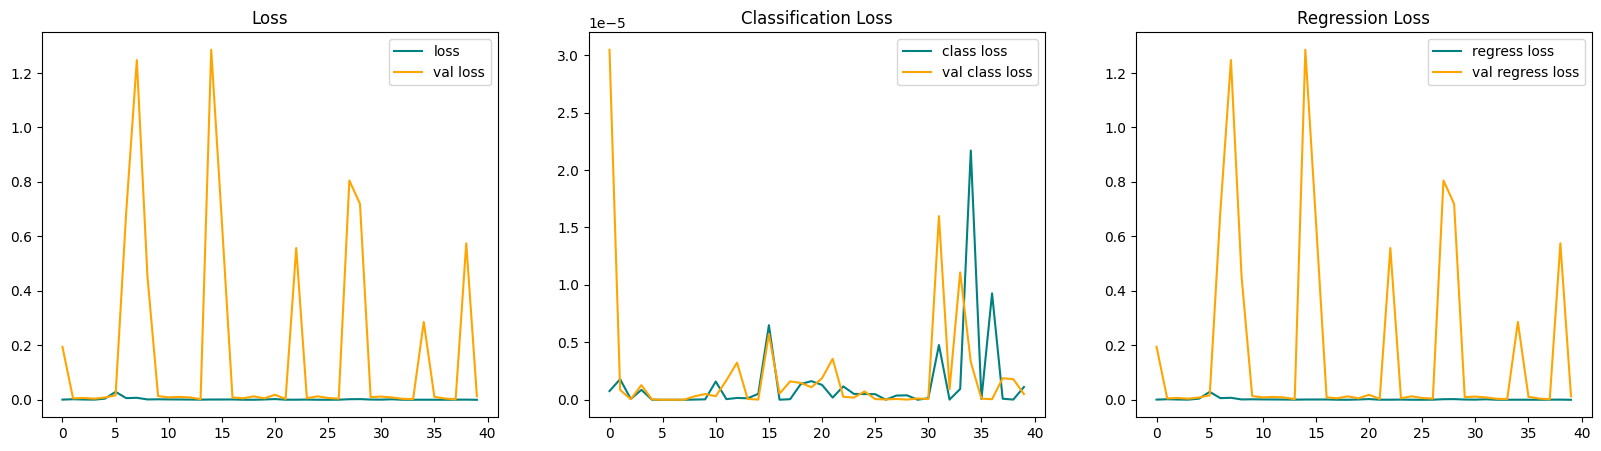

In [98]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))
ax[0].plot(hist.history['total_loss'], color='teal',label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make predictions on Test Set

In [99]:
test_data = test.as_numpy_iterator()

In [100]:
test_sample = test_data.next()

In [ ]:
yhat = facetracker.predict(test_sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [102]:
yhat

[array([[9.9999785e-01],
        [1.1042833e-04],
        [1.0000000e+00],
        [9.9998379e-01],
        [1.0000000e+00],
        [9.9999988e-01],
        [1.0000000e+00],
        [1.3629881e-06]], dtype=float32),
 array([[6.73291385e-02, 2.46581674e-01, 5.18904030e-01, 7.90513039e-01],
        [1.04015344e-03, 8.37905915e-04, 1.35237398e-03, 1.35177013e-03],
        [3.71267974e-01, 2.18944892e-01, 9.30094421e-01, 8.33172500e-01],
        [1.17023297e-01, 3.72796148e-01, 5.20260930e-01, 9.07764614e-01],
        [3.31629038e-01, 2.18563899e-01, 8.16797674e-01, 8.39024305e-01],
        [5.34184217e-01, 3.54829937e-01, 9.84043539e-01, 9.14808393e-01],
        [4.48378533e-01, 2.21982718e-01, 9.91357684e-01, 8.26247692e-01],
        [4.37732997e-05, 9.53174240e-05, 1.21126184e-04, 1.38355113e-04]],
       dtype=float32)]

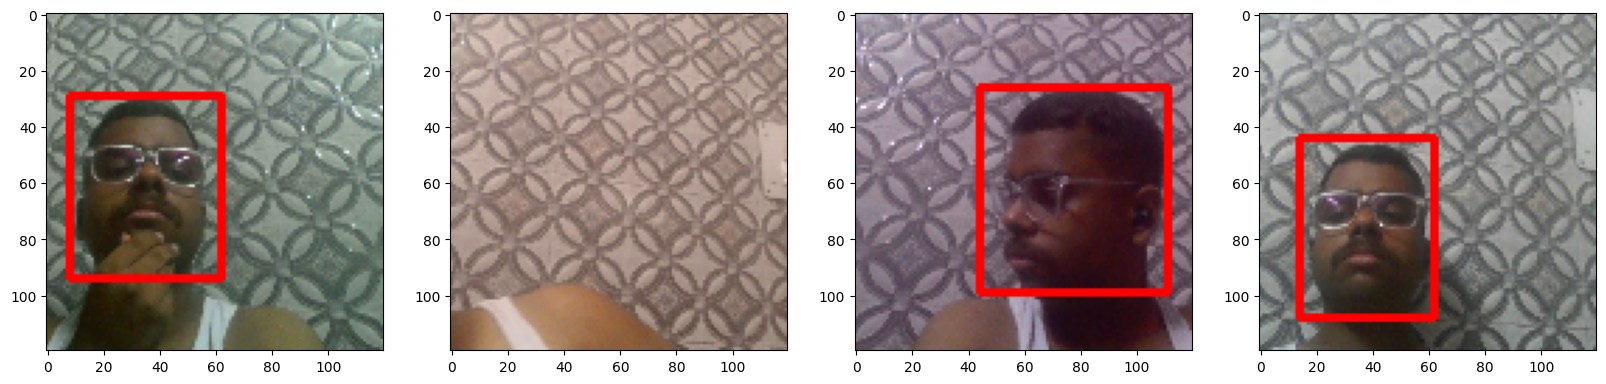

In [103]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]

    # Convert image to uint8 and make it writable
    img_for_draw = (sample_image * 255).astype(np.uint8).copy()

    if yhat[0][idx] > 0.9:
        cv2.rectangle(img_for_draw,
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                            color=(255,0,0), thickness=2)

    ax[idx].imshow(img_for_draw)

### 11.2 Save the model

In [ ]:
from tensorflow.keras.models import load_model
facetracker.save('facetracker_full.keras')

### 11.3 Load Model

In [1]:
from tensorflow import keras
model = keras.models.load_model("facetracker_full.keras")

### Load Model Directly from HuggingFace Hub 

No need to download manually 

In [1]:
import tensorflow as tf
from huggingface_hub import hf_hub_download

# Download from Hugging Face Hub
model_path = hf_hub_download(
    repo_id="PredatorAlpha/Custom-Face-Tracker-Model",  # change if repo name differs
    filename="facetracker_full.keras"
)

# Load into TensorFlow
model = tf.keras.models.load_model(model_path)

C:\Users\samarth\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 11.4 Real-Time Detection

In [2]:
import cv2
import tensorflow as tf
import numpy as np
cap = cv2.VideoCapture(0)
while cap.isOpened():
  _, frame = cap.read()
  frame = frame[50:500, 50:500, :]

  rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  resized = tf.image.resize(rgb, (120,120))

  yhat = model.predict(np.expand_dims(resized/255,0))
  sample_coords = yhat[1][0]

  if yhat[0] > 0.5 :
    # control the main rectangle
    cv2.rectangle(frame,
                  tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)),
                  color=(255,0,0), thickness=2)
    # control label rectangle
    cv2.rectangle(frame,
                  tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), [0,-30])),
                  tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), [80,0])),
                  color=(255,0,0), thickness=2)
    # controls the text rendered
    cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), [0,-5])),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

  cv2.imshow('EyeTrack', frame)


  if cv2.waitKey(1) & 0xFF == ord('q'):
    break
  if cv2.getWindowProperty('EyeTrack', cv2.WND_PROP_VISIBLE) < 1:
    break

cap.release()

cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [3]:
fps = cap.get(cv2.CAP_PROP_FPS)
print(fps)  # Print the frames per second of the video capture

0.0
